<a href="https://colab.research.google.com/github/xanderdavies/unifying-grok-dd/blob/main/toy_grok_dd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Simple Model for Grokking and Double Descent

Xander Davies, Lauro Langosco, Jesse Hoogland, and David Krueger

In [45]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
%matplotlib inline

import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jqhoogland. Use `wandb login --relogin` to force relogin


True

Suppose the dataset contains $n$ distinct and discrete "patterns" (what [Michaud et al. (2023)](https://arxiv.org/abs/2303.13506) call "quanta"). 

Each pattern $i$ has an associated set of properties:
- $f_i$, the frequency of pattern $i$ in the dataset (i.e., the probability that a randomly chosen sample contains pattern $i$).
- $r_i$, the reliability of pattern $i$ (i.e., the probability that the model predicts the correct label for a pattern $i$).

In addition, assume the model learns a set of $m$ distinct subfunctions/behaviors ("circuits"?), each of which is associated 1-to-1 with a pattern. The behavior for pattern $i$ is associated with the following properties:
- $c_i$, the "cost" of implementing that behavior. 
- $b_i \in [0, c_i]$, the "budget" assigned by the model to that behavior. 
- $d_i$, the "difficulty" of learning that behavior.

One way to think about this is that the "cost" is the total amount of weight norm that must be allocated to the behavior, and the "budget" is the amount of weight norm that is actually allocated to the behavior. Alternatively, it could be the number of parameters, or some other composite measure of complexity.

One potential origin for the distinction between cost and difficulty is how many layers are required to implement the behavior. Vanishing/exploding gradients make it harder (=slower) to learn "deep" behaviors. - One place to look for this is in grokking where it's an overly large initial weight norm (which puts you in the exploding gradient regime) that's currently held responsible.
- Another place to look is whether clever reparametrizations like MUP can reduce the difficulty of deep patterns. 

In addition, we specify some weight decay coefficient, $\lambda$, which constrains the total budget, $B^2=\sum_i b_i^2$, available to the model.

We treat each sample, $x^{(j)}$, as a tuple of patterns, $x_j = \{i_1, \ldots, i_k\}$, where $k$ is the number of patterns in the sample. The model predicts the label, $y^{(j)}$, for sample $x^{(j)}$ correctly with the following probability:

$$
p(x^{(j)}) = 1 - \prod_{i \in x_j} \left(1-r_i\left(\frac{b_i}{c_i}\right)\right),
$$

where the product is taken over all the patterns in that model.

The more budget that is allocated to a behavior, the more likely the model is to predict the correct label for that behavior. (Consider sigmoidal relations?)   

This is a model, so we'll identify this probability with the "accuracy" of that sample (even if it accuracies usually aren't fractional).

The total accuracy of the model is the average accuracy of the samples in the dataset:

$$
\mathcal{A} = \frac{1}{n} \sum_{i=1}^n p(x^{(j)}).
$$

And we'll associate a loss, using the cross entropy:

$$
L(x^{(j)}) = -\log p(x^{(j)}),
$$

with total loss, $L = \sum_j L(x^{(j)})$.

The model is trained by minimizing the total loss, $L = \sum_j L(x^{(j)})$, subject to a regularization constraint:

$$
b_i \to b_i - \eta \left(\frac{\partial L}{\partial b_i} - \lambda B^2 \right) 
$$

<!-- We define accuracy $\text{acc}(t)$ at timestep $t$ per:

\begin{align}
\text{acc}(t) &= \text{pred}_1(t) \cup \text{pred}_2(t) \cup \text{pred}_3(t) \\
&= \text{pred}_1(t) + \text{pred}_2(t) + \text{pred}_3(t) - \left(\text{pred}_1(t) \text{pred}_2(t) + \text{pred}_1(t) \text{pred}_3(t) + \text{pred}_2(t) \text{pred}_3(t)\right) + \text{pred}_1(t) \text{pred}_2(t) \text{pred}_3(t) 
\end{align}

We define pattern usage $u_i(t)$ as the proportion of examples seen by $p_i$ at timestep $t$, which is upperbounded by $\text{pred}_i(t)$:
\begin{align}
u_1(t) &= \text{pred}_1(t) - \text{pred}_1(t) \text{pred}_3(t) + \frac{\text{pred}_1(t) \text{pred}_2(t) \text{pred}_3(t) - \text{pred}_1(t) \text{pred}_2(t)}{2} \\
u_2(t) &= \text{pred}_2(t) - \text{pred}_2(t) \text{pred}_3(t) + \frac{\text{pred}_1(t) \text{pred}_2(t) \text{pred}_3(t) - \text{pred}_1(t) \text{pred}_2(t)}{2} \\
u_3(t) &= \text{pred}_3(t)
\end{align}

*Note that $u_1(t) + u_2(t) + u_3(t) \leq 1$, $\forall t \geq 0, \text{pred}_i \leq 1$.*

We then say our model generalizes according to each pattern's generality $g_i$ applied to each usage $u_i(t)$:

\begin{align}
\text{gen}(t) = g_1 u_1(t) + g_2 u_2(t) + g_3 u_3(t)
\end{align} -->

In [31]:
def gen_data(freqs, n_samples = 1000, n_patterns = 10, seed=0):
    samples = jax.random.bernoulli(jax.random.PRNGKey(seed), p=freqs, shape=(n_samples, n_patterns)).astype(jnp.int8)
    return samples
    # Convert to a number between 0 and 2**n_patterns - 1
    # return jnp.sum(samples * 2**jnp.arange(n_patterns), axis=1)

def prob(budgets, costs, reliabilities, sample):
    contributions = (1 - reliabilities * jax.nn.sigmoid((budgets - (costs / 2)) / costs) * sample)
    return 1 - jnp.prod(contributions, axis=1)

def accuracy(budgets, costs, reliabilities, samples):
    return jnp.mean(prob(budgets, costs, reliabilities, samples))

def info(budgets, costs, reliabilities, sample, eps=1e-8):
    return -jnp.log(prob(budgets, costs, reliabilities, sample) + eps)

def loss(budget, costs, reliabilities, samples):
    return jnp.mean(info(budget, costs, reliabilities, samples))

In [36]:
n_patterns = 200

# Zipfian distribution 
freqs = 1. / jnp.arange(1, n_patterns + 1)

costs = jnp.ones(n_patterns)
reliabilities = 1 - freqs
difficulties = jnp.ones(n_patterns)

n_samples = 1000
trainset = gen_data(freqs, seed=1, n_samples=n_samples, n_patterns=n_patterns)
testset = gen_data(freqs, seed=2, n_samples=n_samples, n_patterns=n_patterns)

print("Differences (%):", jnp.mean((jnp.abs(trainset.sum(axis=0) / n_samples - freqs)/freqs * 100)))

Differences (%): 24.803497


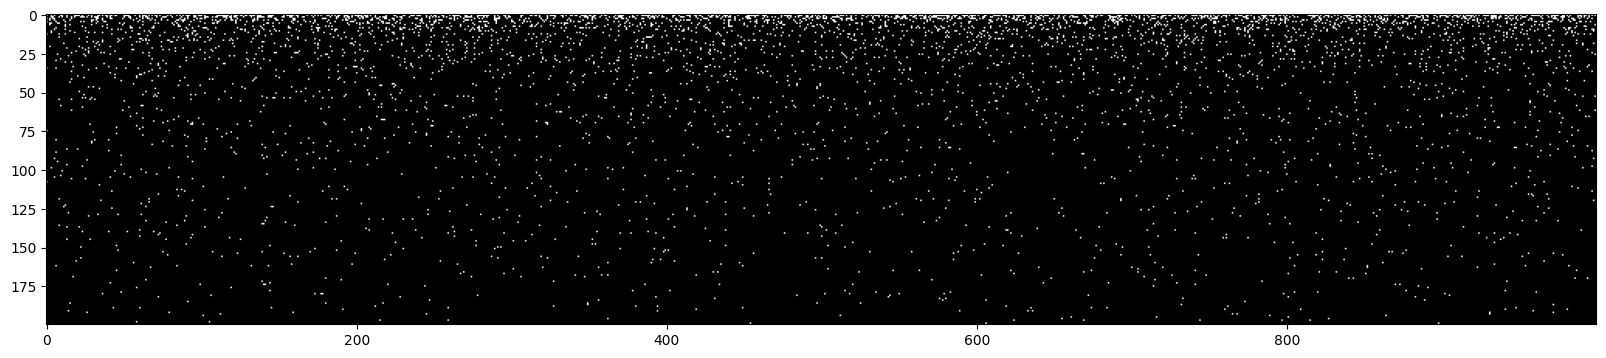

In [37]:
# Visualize the data with plt.imshow

fig = plt.figure(figsize=(20, 10))

plt.imshow(trainset[:, :].T, cmap="gray")
plt.show()

# plt.imshow(testset[:, :].T, cmap="gray")
# plt.show()

In [63]:
def train(trainset, testset, costs, reliabilities, difficulties, lr = 0.1, n_steps = 10_000, beta=0.0001):
    wandb.init(project="toy-model")
    budget = jnp.zeros(n_patterns)

    def loss_train(budget):
        return loss(budget, costs, reliabilities, trainset) 

    def regularization(budget):
        return (beta / 2) * (budget ** 2).sum()

    def log(budget):
        losses = (loss_train(budget), loss(budget, costs, reliabilities, testset))
        
        wandb.log({
            "loss_train": jax.device_get(losses[0]).astype(float).item(),
            "accuracy_train": jax.device_get(jnp.exp(-losses[0])).astype(float).item(),
            "loss_test": jax.device_get(losses[1]).astype(float).item(),
            "accuracy_test": jax.device_get(jnp.exp(-losses[1])).astype(float).item(),
            "budget_total": jax.device_get(budget.sum()).astype(float).item(),
        })

    for _ in range(n_steps):
        log(budget)
        budget = budget - lr * (difficulties * jax.grad(loss_train)(budget) + jax.grad(regularization)(budget))

In [64]:
train(trainset, testset, costs, reliabilities, difficulties)

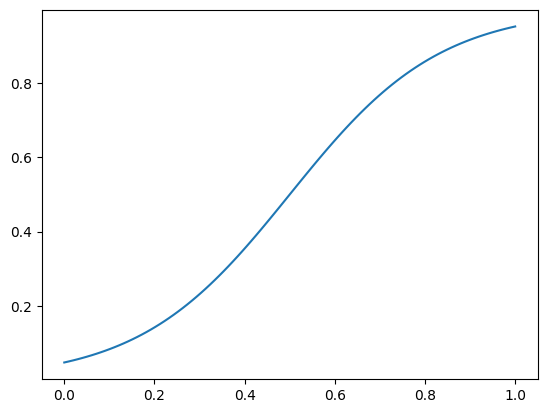

In [14]:
interval = jnp.linspace(0, 1, 100)
values = jax.nn.sigmoid(6 * ((interval) - 0.5))

plt.plot(interval, values)